# Гибридная система идентификации автомобилей

In [23]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from pysim.experiments.utility.graphs_style import (
    get_color, setup_matplotlib, savefig
)

from pysim.models.hybrid.cli import check_vars_for_multiprocessing, run_multiple_simulation
from pysim.models.hybrid.objects import Params
from pysim.models.hybrid.processing import result_processing

In [24]:
def symbol_to_plate_error(prob: float, symbols_in_plate: int) -> float:
    """
    Вероятность ошибки идентификации одного символа номерной таблички
    камерой
    """
    return 1 - (1 - prob) ** (
            1 / symbols_in_plate
    )

## Зависимость вероятности идентификации автомобиля от **вероятности идентификации RFID системой**

### Подготовка входных данных в модель

In [25]:
params_scheme = Params()
params_dict = params_scheme.model_dump()
rfid_probs = np.linspace(0, 1, 25).tolist()
variadic = "rfid_error"
params_dict["rfid_error"] = rfid_probs
# Для каждой кривой своё значение вероятности идентификации камерой
photo_probs_list = [
    symbol_to_plate_error(p, params_scheme.number_plate_symbols_amount)
    for p in np.linspace(0, 1, 5)
]
params_list: list[dict] = []
for photo_err in photo_probs_list:
    params_dict["photo_error"] = photo_err
    params_list.append(copy.deepcopy(params_dict))


In [36]:
np.linspace(0, 1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

### Запуск симуляции

In [26]:
results_list = []
for params in tqdm(params_list, desc="Запуск симуляций", unit="модель"):
    statistica = run_multiple_simulation(variadic, **params)
    results_list.append(result_processing(params, statistica, variadic, print_res=False))

Запуск симуляций:   0%|          | 0/5 [00:00<?, ?модель/s]

In [29]:
res_probs = []
for line in results_list:
    line_probs = []
    for res in line:
        line_probs.append(res.total_prob)
    res_probs.append(line_probs)

## Построение графиков

In [5]:
setup_matplotlib()
DIRECTORY = "Hybrid"

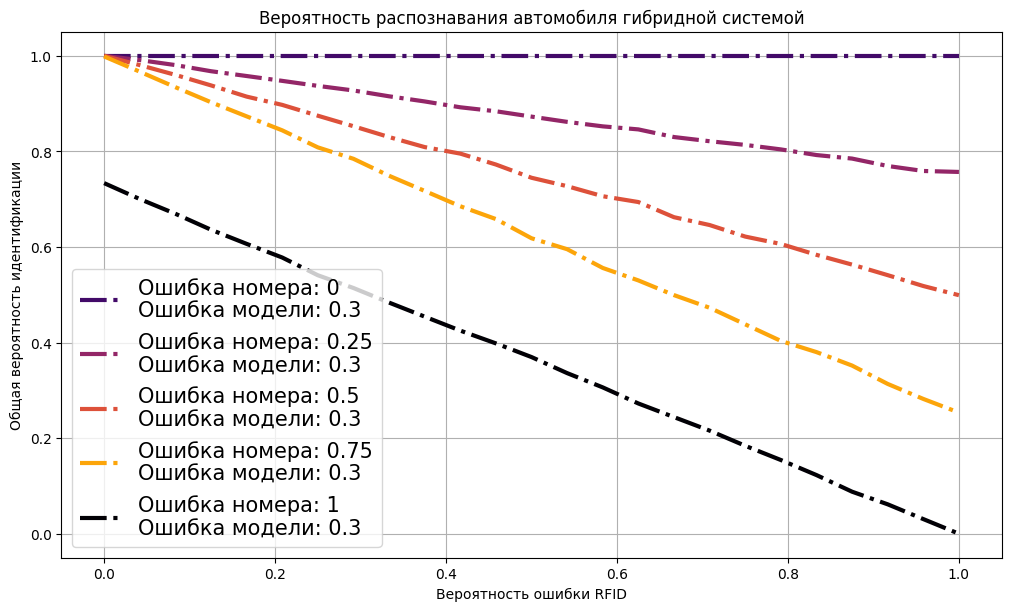

In [37]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

ax.plot(
    rfid_probs, res_probs[0],
    linewidth=3, linestyle="dashdot",
    label=f"Ошибка номера: {0}\nОшибка модели: {params_dict['car_error']}",
    color=get_color(0.2)
)

ax.plot(
    rfid_probs, res_probs[1],
    linewidth=3, linestyle="dashdot",
    label=f"Ошибка номера: {0.25}\nОшибка модели: {params_dict['car_error']}",
    color=get_color(0.4)
)

ax.plot(
    rfid_probs, res_probs[2],
    linewidth=3, linestyle="dashdot",
    label=f"Ошибка номера: {0.5}\nОшибка модели: {params_dict['car_error']}",
    color=get_color(0.6)
)

ax.plot(
    rfid_probs, res_probs[3],
    linewidth=3, linestyle="dashdot",
    label=f"Ошибка номера: {0.75}\nОшибка модели: {params_dict['car_error']}",
    color=get_color(0.8)
)

ax.plot(
    rfid_probs, res_probs[4],
    linewidth=3, linestyle="dashdot",
    label=f"Ошибка номера: {1}\nОшибка модели: {params_dict['car_error']}",
    color=get_color(1)
)
ax.set_xlabel("Вероятность ошибки RFID")
ax.set_ylabel("Общая вероятность идентификации")
plt.tick_params(axis="both", which="major")
plt.title("Вероятность распознавания автомобиля гибридной системой")
plt.legend(prop={"size":15})
plt.grid()

# savefig(name=f"", directory=DIRECTORY)

## Зависимость вероятности идентификации автомобиля от **вероятности фотофиксации**
Семейство кривых для разных вероятностей RFID

## Зависимость вероятности идентификации автомобиля от **вероятности определения модели**
Семейство кривых для разных вероятностей RFID и фотофиксации

## Зависимость доли коллизий от **вероятности определения модели**
Семейство кривых для разных вероятностей RFID и фотофиксации

## Количество неразрешённых коллизий при больших вероятностях ошибки идентификации

## Количество неправильно разрешённых коллизий при больших вероятностях ошибки идентификации